# Module 6 Problem Set Solutions
This is the solutions file for Module 6's Problem Set! (Hopefully) useful comments and markdown cells found throughout!

## Overview
This problem set contains some examples of two types of models discussed in Friday's lectures: decision trees and random forests. **The code in this Problem Set should be very applicable to Homework 1's section on Decision Trees**. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
import random

## Reproducibility

Often when working with ML data we will perform some random actions (e.g., splitting randomly our training/validation/testing data or performing random transforms). To aid with reproducibility we can set the random state for numpy and python's random modules by speficifying the seed parameter as done in the cell below. *When training your own models, especially larger-scale "deep learning" models, this can negatively impact the speed of training.*

In [2]:
np.random.seed(3621)
random.seed(3621)

## Data

The dataset we will be using for today's Problem Set comes from the BUPA Medical Research Ltd. database (donated by Richard S. Forsyth). This data is licensed under the CC BY 4.0 license. A link to the dataset can be found [here](https://archive.ics.uci.edu/dataset/60/liver+disorders).

### UCI ML Repo files

The UCI Machine Learning Repository is a great place to find datasets for use in this class (e.g. Homeworks, Projects). You can import the data from these datasets using the `ucimlrepo` library (`pip install ucimlrepo`) and following the appropriate documentation. An example for loading this dataset below (provided you have that libary installed).

In [ ]:
# Source: UCIML Repo Documentation
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
liver_disorders = fetch_ucirepo(id=60) 
  
# data (as pandas dataframes) 
X = liver_disorders.data.features 
y = liver_disorders.data.targets 
  
# metadata 
print(liver_disorders.metadata) 
  
# variable information 
print(liver_disorders.variables)

In [3]:
# Loading the dataset as normal
liver_disorders = pd.read_csv('data/bupa.csv', header=0)
liver_disorders

,mcv,alkphos,sgpt,sgot,gammagt,drinks
0,85,92,45,27,31,0.0
1,85,64,59,32,23,0.0
2,86,54,33,16,54,0.0
3,91,78,34,24,36,0.0
4,87,70,12,28,10,0.0
...,...,...,...,...,...,...
340,99,75,26,24,41,12.0
341,96,69,53,43,203,12.0
342,98,77,55,35,89,15.0
343,91,68,27,26,14,16.0


Our goal will be to predict the number of drinks (in half-pints) from an indivudual (the `drinks` column) based on the other predictors in the file. **Separate the target from the predictors.**

In [4]:
predictors = liver_disorders.iloc[:, :-1]
targets    = liver_disorders.iloc[:, -1]

**Split the data into training and testing data, using an 80/20 split.**

In [5]:
training_predictors, testing_predictors, training_targets, testing_targets = train_test_split(predictors, 
                                                                                              targets, 
                                                                                              train_size=0.8)

## Decision Tree

**Using either a DecisionTreeRegressor or a DecisionTreeClassifier, fit a Decison Tree to our data?**

In [6]:
tree = DecisionTreeRegressor()  # The task is regression!
tree.fit(training_predictors, training_targets)  # The .fit(predictors, targets) is how scikit works! 

DecisionTreeRegressor()

**Use the plot_tree method imported at the beginning to display our tree**

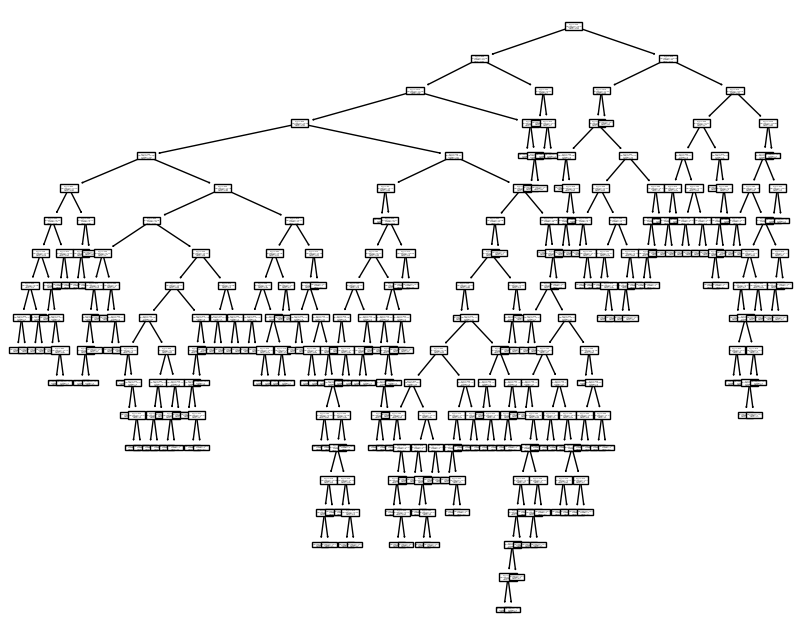

In [7]:
plt.figure(figsize=(10,8))
# Add your one line of code below 
plot_tree(tree)
plt.show()  # plt.show will remove all of the weird print statements before the figure

**Is there something that may be an issue with our tree?**

The tree is *very* complex - all these decisions we can't even read the tree well. Our tree is likely *overfitting* our training set. 

**Evaluate the tree on our training and testing dataset using mean squared error (Why MSE and not accuracy?).**

In [8]:
from sklearn.metrics import mean_squared_error

# Create variables for our predictions on both the training and testing sets
training_predictions = tree.predict(training_predictors)
testing_predictions  = tree.predict(testing_predictors)

# Create variables to store our error
training_error = mean_squared_error(training_targets, training_predictions)
testing_error  = mean_squared_error(testing_targets, testing_predictions)

# We use MSE here instead of accuracy because we are performing regression! 
print(f'Model obtained MSE of {training_error} on the training set and '
      f'{round(testing_error, 3)} on the testing set')

Model obtained MSE of 0.0 on the training set and 25.79 on the testing set


**What is happening with our model? How can we fix this?**

Our model is *definitely* overfitting - it is perfect on the training set and not performing well on the testing set. We can fix this by pruning our tree - setting the max depth or minimum number of samples in a leaf.

**By default, our tree is fit using squared error as the criterion. Create a new tree using absolute error as the criterion, and prune our tree by setting the maximum depth of our tree to be 4.**

In [9]:
pruned_tree = DecisionTreeRegressor(max_depth=4, criterion='absolute_error')
pruned_tree.fit(training_predictors, training_targets)

DecisionTreeRegressor(criterion='absolute_error', max_depth=4)

**Show our tree, and evaluate the tree on the training and testing dataset.**

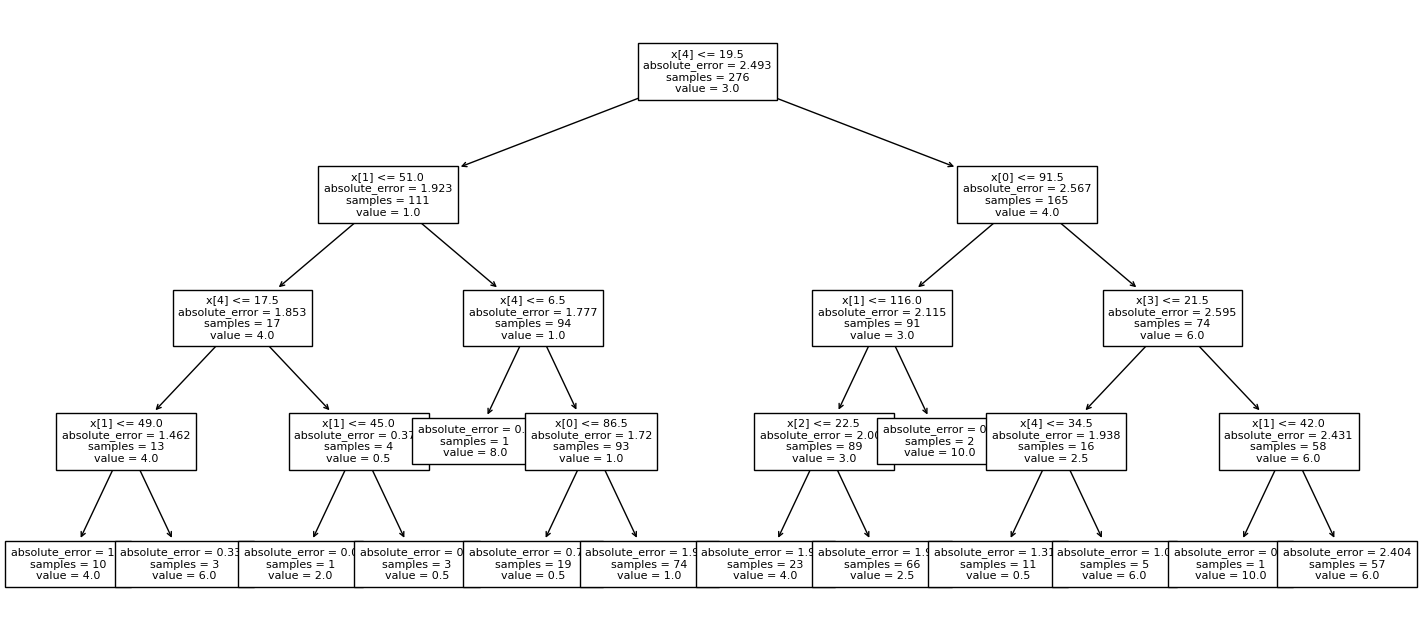

Model obtained MSE of 7.537 on the training set and 15.884 on the testing set


In [10]:
plt.figure(figsize=(18, 8))
# Plot the tree as we did last time. You can yse the fontsize keyword argument to make it more readable
plot_tree(pruned_tree, fontsize=8)
plt.show()

# Make varaibles for our predictions (training and testing)
training_predictions_pruned = pruned_tree.predict(training_predictors)
testing_predictions_pruned  = pruned_tree.predict(testing_predictors)

# Make variables for our error
pruned_train_error = mean_squared_error(training_targets, training_predictions_pruned)
pruned_test_error  = mean_squared_error(testing_targets, testing_predictions_pruned)

# Fill in the f-string
print(f'Model obtained MSE of {round(pruned_train_error, 3)} on the training set and '
      f'{round(pruned_test_error, 3)} on the testing set')

**Did the pruning help? How can we decide which is the best max_depth for our tree?**

The pruning did help! Our error on the testing dataset went down - this is the goal of our pruning. Increase error on the training set and decrease it on an unseen test set! We can find which is the best max_depth in many ways, but the easiest is to brute-force calculate for all max depths up to a certain value, and plot our training and testing loss on the y-axis for each.

## Random Forest 

**What is a Random Forest?**

A Random Forest is an algorithm that uses a collection of decision trees. Each tree is trained on a randomly selected subset of the training data, and the trees' output is averaged (in this case,  because we are performing regression) or a majority vote is used (in classification). There are lots of finer details involved, including feature bagging and splitting each testing dataset into 2/3 training and 1/3 validation (and using the validation data to assist in making predictions).

**Create and fit random forest model for our data with max_depth set to 5.**

In [11]:
random_forest = RandomForestRegressor(max_depth=5)
random_forest.fit(training_predictors, training_targets)

RandomForestRegressor(max_depth=5)

**Evaluate our Random Forest. Was it better than our normal decision tree?**

In [12]:
# Prediction variables
random_forest_training_predictions = random_forest.predict(training_predictors)
random_forest_testing_predictions  = random_forest.predict(testing_predictors)

# Error variables 
rf_train_error = mean_squared_error(training_targets, random_forest_training_predictions)
rf_test_error  = mean_squared_error(testing_targets, random_forest_testing_predictions)

# Fill in f-string
print(f'Model obtained MSE of {round(rf_train_error, 3)} on the training set and '
      f'{round(rf_test_error, 3)} on the testing set')

Model obtained MSE of 4.423 on the training set and 11.919 on the testing set


It was better! We can further finetune our Random Forest just like we did our Decision Tree to achieve even better performance (an exercise left to the reader)